## Fine-Tuning with Sentence Transformers
In this notebook, we will learn about `sentence_transformers` library and then we will fine-tune a `bert-base-uncased` model with 2 different type of datasets:
- Triplets
- Sentence pairs with labels (SNLI)

Let's first install the required dependencies and modules

We will use `all-MiniLM-L6-v2` to play around with sentence transformer features 

In [1]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

/home/mrzaizai2k/code_Bao/LLM-with-RAG/notebook


In [2]:
# model
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")

/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Converting text to embeddings
Let’s first try converting a given text into embeddings. You might also have used openai embeddings to get the embeddings of a given text but it charges money to use their embedding model so as an alternative you can use models from huggingface or any other opensource embedding model with sentence transformers to generate vector embeddings for your sentence.

Now we will define the sentences for which we want to generate the embeddings in an array and then we can use `encode` method from our model to generate embeddings.

In [3]:
# Generating Embeddings

# Our sentences we like to encode
sentences = [
    "This framework generates embeddings for each input sentence",
    "Sentences are passed as a list of string.",
    "The quick brown fox jumps over the lazy dog.",
]

# Sentences are encoded by calling model.encode()
sentence_embeddings = model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    # print("Embedding:", embedding)
    # print("")

Sentence: This framework generates embeddings for each input sentence
Sentence: Sentences are passed as a list of string.
Sentence: The quick brown fox jumps over the lazy dog.


### Cosine Similarity between Sentences

You can use cosine similarity to find out the similarity between 2 sentences. Sentence transformers allow us to find the cosine similarity score between 2 sentences so let’s see it in action!

First, we will import the required modules and convert our sentences into embeddings using the same model we used before

In [4]:
 # Finding cosine similarity
from sentence_transformers import SentenceTransformer, util

# Sentences are encoded by calling model.encode()
emb1 = model.encode("This is a red cat with a hat.")
emb2 = model.encode("Have you seen my red cat?")


Now we can find the cosine similarity between these 2 embeddings using `util.cos_sim` method

In [5]:
cos_sim = util.cos_sim(emb1, emb2)
print("Cosine-Similarity:", cos_sim)

Cosine-Similarity: tensor([[0.5840]])


### Semantic Search
In semantic search, you have a query (it can be a sentence or an image) and you convert that query into embeddings and then you find the similar sentence embeddings for the given query embedding using semantic search by performing cosine similarity.

Once we get all the similarity scores for different sentences, we then sort the sentences based on the scores in descending order meaning that the most similar sentence or a sentence with highest similarity score will be at the top and we can specify the number of similar sentences we want as “k”.

Let’s see it in action!

First we will define the existing sentences which works as a database meaning that we want to find the top k similar sentences from this list. We will have to convert these sentences into encodings so that we can perform cosine similarity on them.

In [6]:
# Semantic Search
from sentence_transformers import SentenceTransformer, util
import torch

# Corpus with example sentences
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

Now we will define our queries and for each query we will find top 3 similar sentences from corpus

In [7]:
# Query sentences:
queries = [
    "A man is eating pasta.",
    "Someone in a gorilla costume is playing a set of drums.",
    "A cheetah chases prey on across a field.",
]
top_k = min(5, len(corpus))
for query in queries:
    query_embedding = model.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")
    # print(top_results)
    for score, idx in zip(top_results[0], top_results[1]):
        print(corpus[idx], "(Score: {:.4f})".format(score))





Query: A man is eating pasta.

Top 5 most similar sentences in corpus:
A man is eating food. (Score: 0.7098)
A man is eating a piece of bread. (Score: 0.6306)
A man is riding a horse. (Score: 0.3504)
A man is riding a white horse on an enclosed ground. (Score: 0.3053)
A monkey is playing drums. (Score: 0.2759)




Query: Someone in a gorilla costume is playing a set of drums.

Top 5 most similar sentences in corpus:
A monkey is playing drums. (Score: 0.7512)
A woman is playing violin. (Score: 0.3348)
A man is eating a piece of bread. (Score: 0.2217)
A cheetah is running behind its prey. (Score: 0.1697)
A man is riding a horse. (Score: 0.1467)




Query: A cheetah chases prey on across a field.

Top 5 most similar sentences in corpus:
A cheetah is running behind its prey. (Score: 0.7739)
A man is riding a white horse on an enclosed ground. (Score: 0.3257)
A man is riding a horse. (Score: 0.3057)
A monkey is playing drums. (Score: 0.2792)
Two men pushed carts through the woods. (Scor

Additionaly, instead of using `util.cos_sim` and then getting the top k results, you can use `util.semantic_search` method to do the same thing easily.

In [8]:
# Using semantic_search utility from sentence transformers
top_k = 5
for query in queries:
    query_embedding = model.encode(query, convert_to_tensor=True)
    similar_results = util.semantic_search(query_embeddings=query_embedding,corpus_embeddings=corpus_embeddings,top_k=top_k)
    print("===============\n")
    print(f"Similar Sentences for '{query}'")
    for result in similar_results[0]:
      print(f"{corpus[result['corpus_id']]} (score: {result['score']})")


Similar Sentences for 'A man is eating pasta.'
A man is eating food. (score: 0.7098211050033569)
A man is eating a piece of bread. (score: 0.6305689811706543)
A man is riding a horse. (score: 0.3504316806793213)
A man is riding a white horse on an enclosed ground. (score: 0.30528172850608826)
A monkey is playing drums. (score: 0.2759323716163635)

Similar Sentences for 'Someone in a gorilla costume is playing a set of drums.'
A monkey is playing drums. (score: 0.7512155175209045)
A woman is playing violin. (score: 0.3348246216773987)
A man is eating a piece of bread. (score: 0.22166402637958527)
A cheetah is running behind its prey. (score: 0.16970489919185638)
A man is riding a horse. (score: 0.14669592678546906)

Similar Sentences for 'A cheetah chases prey on across a field.'
A cheetah is running behind its prey. (score: 0.7739089727401733)
A man is riding a white horse on an enclosed ground. (score: 0.32570168375968933)
A man is riding a horse. (score: 0.3056842088699341)
A monkey

## Training a model using a triplets dataset
Now we have enough knowledge about sentence transformers, so let's fine-tune a base model from scratch
Please [read the blog](https://www.ionio.ai/blog/fine-tuning-embedding-models-using-sentence-transformers-code-included) to read about the fine-tuning process in more detail.

Let’s first pull our base model and apply pooling on it so that we can get fixed 768 sized embedding array in output

In [9]:
# Training a bert model using sentence transformer
from sentence_transformers import SentenceTransformer, models
import torch

word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Now let’s pull our dataset, we are going to use `embedding-data/QQP_triplets` but you can use any other triplet dataset too if you want

In [10]:
# Using QQP Triples dataset for training
from datasets import load_dataset

dataset_id = "embedding-data/QQP_triplets"
dataset = load_dataset(dataset_id)

Let’s take a look at how each data looks like in dataset

In [11]:
dataset['train']['set'][0]

{'query': 'Why in India do we not have one on one political debate as in USA?',
 'pos': ['Why cant we have a public debate between politicians in India like the one in US?'],
 'neg': ['Can people on Quora stop India Pakistan debate? We are sick and tired seeing this everyday in bulk?',
  'Why do politicians, instead of having a decent debate on issues going in and around the world, end up fighting always?',
  'Can educated politicians make a difference in India?',
  'What are some unusual aspects about politics and government in India?',
  'What is debate?',
  'Why does civic public communication and discourse seem so hollow in modern India?',
  'What is a Parliamentary debate?',
  "Why do we always have two candidates at the U.S. presidential debate. yet the ballot has about 7 candidates? Isn't that a misrepresentation of democracy?",
  'Why is civic public communication and discourse so hollow in modern India?',
  "Aren't the Presidential debates teaching our whole country terrible c

As we can see, each example have a query, a positive sentence which is similar to that query and a list of negative sentences which are not similar to query.

We can’t directly pass this dataset examples into our model because first we have to convert them to a specific format that sentence transformers and model can understand. Every training example must be in “InputExample” format in sentence transformers so we will convert our dataset data into this format.

We will also take only first sentence from both `pos` and `neg` arrays to make it easy but in production scenario, you might need to pass the full array for better performance and accuracy

In [12]:
from sentence_transformers import InputExample

train_examples = []
train_data = dataset['train']['set']
# For agility we only 1/2 of our available data
# n_examples = dataset['train'].num_rows // 4
for i in range(0,1000):
  example = train_data[i]
  train_examples.append(InputExample(texts=[example['query'],example['pos'][0],example['neg'][0]]))

Now let’s create our dataloader

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

Now let’s define our loss function. We can use “losses” class from sentence transformers which allows us to get different loss functions that we discussed above.

We just have to attach the model to triplet loss function

In [14]:
from sentence_transformers import losses
train_loss = losses.TripletLoss(model)

And now we are ready, let’s combine everything we prepared and fine-tune the model using `model.fit` method which takes dataloader and loss function as a train objectives.

In [15]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=4)

Step,Training Loss


Now let’s push this fine-tuned model on huggingface so that we can share it with other people and they can also see what we cooked!

First login with huggingface using your access token

In [24]:
# from huggingface_hub import notebook_login

# notebook_login()

After that. call `save_to_hub` method to push your model on huggingface

In [25]:
# model.save_to_hub(
#     "distilroberta-base-sentence-transformer-triplets", # Give a name to your model
#     organization="0xSH1V4M" # Your Huggingface Username
#     train_datasets=["embedding-data/QQP_triplets"],
#     )

In [26]:
from sentence_transformers import SentenceTransformer, models
# Evaluation
sentences = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]

Let’s first get the embeddings  of these sentences using “bert-base-uncased” model which is our base model

In [27]:
model = SentenceTransformer("bert-base-uncased")
# Sentences are encoded by calling model.encode()
sentence_embeddings = model.encode(sentences)

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.
/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Now let’s reduce the embedding dimensions using TSNE

In [28]:
import numpy as np
from sklearn.manifold import TSNE
embeddings = np.array(sentence_embeddings)
tsne = TSNE(n_components=2, random_state=42,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)

Now we have 2D embeddings, we will do clustering to classify all these embeddings into different classes so that it will be easy for us to visualize how these models are classifying different embeddings and the positions of embeddings in vector space

In [29]:
from sklearn.cluster import KMeans
# Perform kmean clustering
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[1 1 1 1 1 0 1 1 2]


/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


If you print the `cluster_assignment` array then you will see the class labels for every sentence which shows the class of each sentence

Now let’s plot these embeddings in 2D vector space using metaplotlib

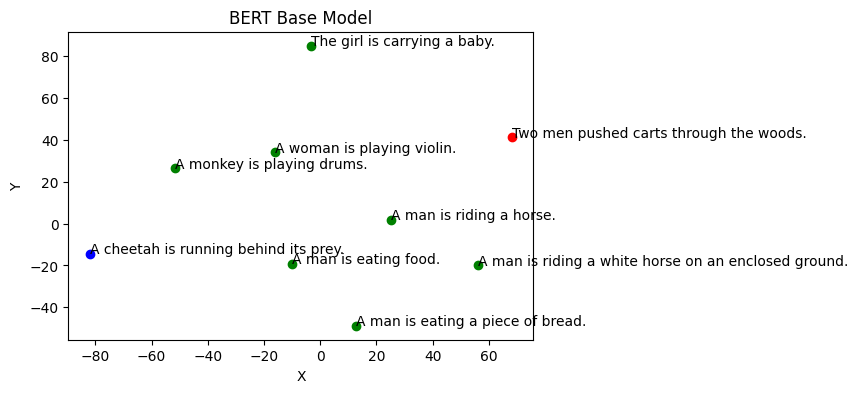

In [30]:
import matplotlib.pyplot as plt

# Assuming your 2D embeddings are stored in 'embeddings_2d'

# Create a scatter plot
plt.figure(figsize=(6, 4))  # Adjust figure size as needed
colors = ["red","green","blue"]

for index,embedding in enumerate(embeddings_2d):
  plt.scatter(embedding[0],embedding[1],color=colors[cluster_assignment[index]])
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])  # Use first two columns for x and y

# Optional: Add labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("BERT Base Model")

# Optional: Add sentence labels (consider using for small datasets like yours)
for i, sentence in enumerate(sentences):
  plt.annotate(sentence, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.grid(False)
plt.show()

### Plotting the results of fine-tuned model using triplets

First pull the model from huggingface

In [31]:
model = model

Prepare the sentence embeddings

In [32]:
sentences = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]
sentence_embeddings = model.encode(sentences)

Apply KMeans algorithm to perform clustering on embeddings

In [33]:
from sklearn.cluster import KMeans
# Perform kmean clustering
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[0 0 0 0 0 2 0 0 1]


/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Apply TSNE algorithm for dimension reduction

In [34]:
embeddings = np.array(sentence_embeddings)
tsne = TSNE(n_components=2, random_state=42,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)
# print(embeddings_2d)

Plot the 2D embeddings on 2D graph

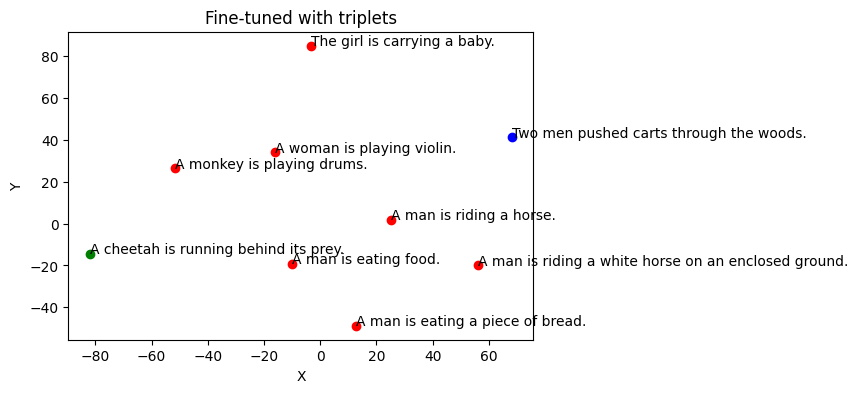

In [35]:
import matplotlib.pyplot as plt
colors = ["red","green","blue"]

# Create a scatter plot
plt.figure(figsize=(6, 4))  # Adjust figure size as needed
for index,embedding in enumerate(embeddings_2d):
  plt.scatter(embedding[0],embedding[1],color=colors[cluster_assignment[index]])
  # plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])  # Use first two columns for x and y

# Optional: Add labels and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Fine-tuned with triplets")

# Optional: Add sentence labels (consider using for small datasets like yours)
for i, sentence in enumerate(sentences):
  plt.annotate(sentence, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.grid(False)
plt.show()